In [2]:
from scipy import special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

### Infinite line source

In [4]:
L_list=np.array([10,10])
r=0.125+0.5 #radius (m)
time=3600*24*7 #time (s)
# Geological parameters
k=np.array([1.5,3]) #thermal conductivity (W/mK)
gamma=np.array([1500,1500]) #density (kg/m^3)
Cp=np.array([800,800]) #heat capacity (J/kgK)
a=k/(gamma*Cp) #diffusivity (m^2/s)
q=145/2*(1+k[0]*np.sum(L_list)/(np.sum(k*L_list))) #heat flux (W/m)

print(q/(4*np.pi*k[0])*special.exp1(r**2/(4*a[0]*time)))

10.221345606474122


### Multi-layer finite line source

In [3]:
def delta_T_1_j(x_start,x_end,rA,hA,a,t,q,k):
    result=[]
    for h0 in hA:
        result_temp=integrate.quad(lambda x: special.erfc(np.sqrt((x-h0)**2+rA**2)/(2*np.sqrt(a*t)))/np.sqrt((x-h0)**2+rA**2)\
                                   -special.erfc(np.sqrt((x+h0)**2+rA**2)/(2*np.sqrt(a*t)))/np.sqrt((x+h0)**2+rA**2),\
                                   x_start,x_end)
        result.append(q/(4*np.pi*k)*result_temp[0])
    return result

def s_ratio(L_list,j,i,x,hA):
    s_ratio_list=[]
    if j>i:
        for k in range(i,j+1):
            if k==i:
                s_ratio_list.append((np.sum(L_list[:i+1])-x)/(hA-x))
            elif k==j:
                s_ratio_list.append((hA-np.sum(L_list[:j]))/(hA-x))
            else:
                s_ratio_list.append(L_list[k]/(hA-x))
    else:
        for k in range(i,j-1,-1):
            if k==i:
                s_ratio_list.append(x-(np.sum(L_list[:i]))/(x-hA))
            elif k==j:
                s_ratio_list.append((np.sum(L_list[:j+1])-hA)/(x-hA))
            else:
                s_ratio_list.append(L_list[k]/(x-hA))
    return np.array(s_ratio_list)

def s_ratio_quotation(L_list,j,i,x,hA):
    s_ratio_list=[]
    index=np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()
    for k in range(0,i+j+2):
        if k==0:
            s_ratio_list.append((x-np.sum(L_list[:i]))/(x+hA))
        elif k==i+j+1:
            s_ratio_list.append((hA-np.sum(L_list[:j]))/(x+hA))
        else:
            s_ratio_list.append(L_list[index[k]]/(x+hA))
    return np.array(s_ratio_list)

def delta_T_2_ij(k_list,gamma_list,Cp_list,L_list,rA,hA,t,q,j,i):
    result=[]
    for h0 in hA:
        if j>i:
            k_comp=lambda x: 1/np.sum(s_ratio(L_list,j,i,x,h0)/k_list[i:j+1])
            gamma_comp=lambda x: np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i:j+1])
            Cp_comp=lambda x: np.sum(Cp_list[i:j+1]*s_ratio(L_list,j,i,x,h0)*gamma_list[i:j+1]\
                                 /np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i:j+1]))
        else:
            if j-1>-1:
                k_comp=lambda x: 1/np.sum(s_ratio(L_list,j,i,x,h0)/k_list[i:j-1:-1])
                gamma_comp=lambda x: np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i:j-1:-1])
                Cp_comp=lambda x: np.sum(Cp_list[i:j-1:-1]*s_ratio(L_list,j,i,x,h0)*gamma_list[i:j-1:-1]\
                                 /np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i:j-1:-1]))
            else:
                k_comp=lambda x: 1/np.sum(s_ratio(L_list,j,i,x,h0)/k_list[i::-1])
                gamma_comp=lambda x: np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i::-1])
                Cp_comp=lambda x: np.sum(Cp_list[i::-1]*s_ratio(L_list,j,i,x,h0)*gamma_list[i::-1]\
                                 /np.sum(s_ratio(L_list,j,i,x,h0)*gamma_list[i::-1]))
        k_comp_quotation=lambda x: 1/np.sum(s_ratio_quotation(L_list,j,i,x,h0)\
                                        /k_list[np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()])
        gamma_comp_quotation=lambda x: np.sum(s_ratio_quotation(L_list,j,i,x,h0)\
                                          *gamma_list[np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()])
        Cp_comp_quotation=lambda x: np.sum(Cp_list[np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()]\
                                       *s_ratio_quotation(L_list,j,i,x,h0)\
                                       *gamma_list[np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()]\
                                 /np.sum(s_ratio_quotation(L_list,j,i,x,h0)\
                                         *gamma_list[np.concatenate((np.arange(i,-1,-1),np.arange(0,j+1))).tolist()]))
        
        a_comp=lambda x: k_comp(x)/(Cp_comp(x)*gamma_comp(x))
        a_comp_quotation=lambda x: k_comp_quotation(x)/(Cp_comp_quotation(x)*gamma_comp_quotation(x))
    
        result_temp=integrate.quad(lambda x: special.erfc(np.sqrt((x-h0)**2+rA**2)/(2*np.sqrt(a_comp(x)*t)))\
                                   /(k_comp(x)*np.sqrt((x-h0)**2+rA**2))-\
                                   special.erfc(np.sqrt((x+h0)**2+rA**2)/(2*np.sqrt(a_comp_quotation(x)*t)))\
                                   /(k_comp_quotation(x)*np.sqrt((x+h0)**2+rA**2)),np.sum(L_list[:i]),\
                                   np.sum(L_list[:i+1]))
        result.append(q/(4*np.pi)*result_temp[0])
    return result

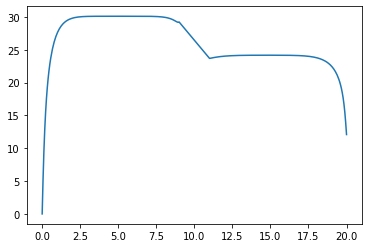

In [10]:
# simulation inputs
L_list=np.array([10,10]) #depth list (m)
r=0.125+0 #radius (m)
h_list=np.concatenate((np.linspace(0,10-1,161),np.linspace(10+1,20,161))) #depth (m)
time=3600*24*7 #time (s)
index_list=[0,1]

# Geological parameters
k=np.array([1.5,3]) #thermal conductivity (W/mK)
gamma=np.array([1500,1500]) #density (kg/m^3)
Cp=np.array([800,800]) #heat capacity (J/kgK)
q=145 #heat flux (W/m)
a=k/(gamma*Cp) #diffusivity (m^2/s)

result_list=[]
for h_value in h_list:
    for j in index_list:
        if h_value<=np.sum(L_list[:j+1]) and h_value>=np.sum(L_list[:j]):
            h=[h_value]
            q_j=q/2*(1+k[j]*np.sum(L_list)/(np.sum(k*L_list)))
            result=delta_T_1_j(np.sum(L_list[:j]),np.sum(L_list[:j+1]),r,h,a[j],time,q_j,k[j])[0]
            for i in index_list:
                if j!=i:
                    q_i=q/2*(1+k[i]*np.sum(L_list)/(np.sum(k*L_list)))
                    result+=delta_T_2_ij(k,gamma,Cp,L_list,r,h,time,q_i,j,i)[0]
    result_list.append(result)

gg=np.array(result_list)
index=np.arange(0,len(h_list)).tolist()
for k in np.argwhere(np.isnan(gg)):
    index.remove(k[0])
h_list=h_list[index]
gg=gg[index]
plt.plot(h_list,gg)